##### Copyright 2022 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Classifier with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to classify images. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/image_classifier/python) to learn more about configuration options that this solution supports.

## Preparation

Let's start with installing MediaPipe.

In [ ]:
!pip install -q flatbuffers==2.0.0
!pip install -q mediapipe==0.9.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 2.0 which is incompatible.
     |████████████████████████████████| 33.0 MB 168 kB/s 


Then download an off-the-shelf model. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/image_classifier#models) for more image classification models that you can use.

In [ ]:
!wget -O classifier.tflite -q https://storage.googleapis.com/mediapipe-tasks/image_classifier/efficientnet_lite0_fp32.tflite

## Visualization utilities



In [ ]:
#@markdown We implemented some functions to visualize the image classification results. <br/> Run the following cell to activate the functions.
from matplotlib import pyplot as plt
plt.rcParams.update({
    'axes.spines.top': False, 
    'axes.spines.right': False, 
    'axes.spines.left': False, 
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(images, predictions):
    """Displays a batch of images with the classifications."""
    # Images and predictions.
    images = [image.numpy_view() for image in images]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows
        
    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # Display.
    for i, (image, prediction) in enumerate(zip(images[:rows*cols], predictions[:rows*cols])):
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3 
        subplot = display_one_image(image, prediction, subplot, titlesize=dynamic_titlesize)
    
    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

## Download test images

Let's grab some test images that we'll use later. 

In [ ]:
import urllib

IMAGE_FILENAMES = ['burger.jpg', 'cat.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

Then let's check out the images.

burger.jpg


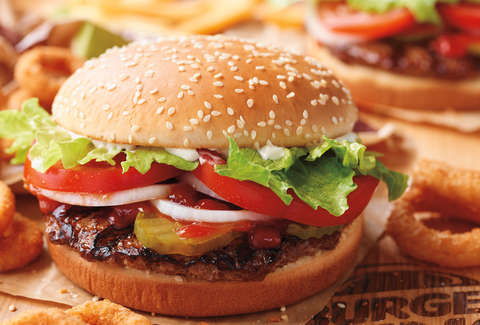

cat.jpg


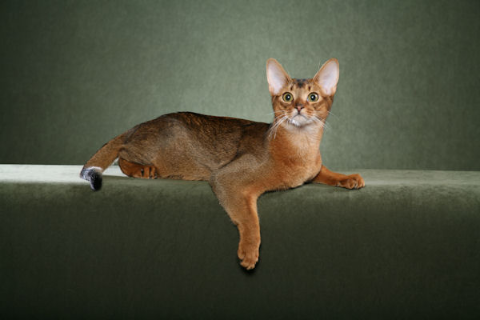

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the images.

images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)   
  resize_and_show(image)

## Running inference and visualizing the results

Here are the steps to run image classification using MediaPipe:

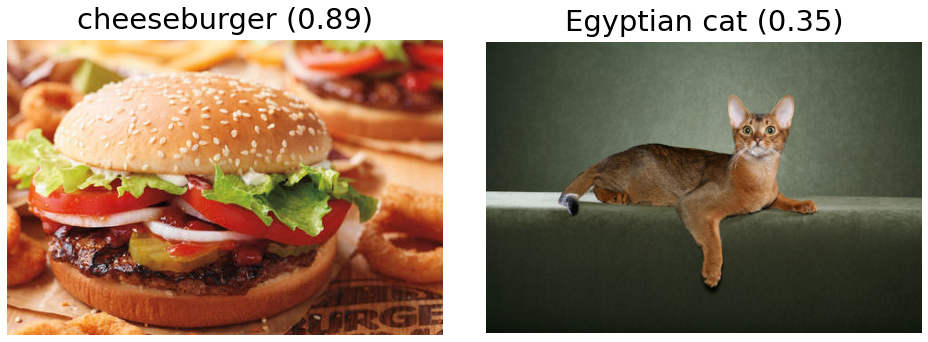

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python.components import processors
from mediapipe.tasks.python import vision

# STEP 2: Create an ImageClassifier object.
base_options = python.BaseOptions(model_asset_path='classifier.tflite')
custom_classifier_options = processors.ClassifierOptions(max_results=4)
options = vision.ImageClassifierOptions(
    base_options=base_options, classifier_options=custom_classifier_options)
classifier = vision.ImageClassifier.create_from_options(options)

images = []
predictions = []
for image_name in IMAGE_FILENAMES:
  # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_name)
  
  # STEP 4: Classify the input image.
  classification_result = classifier.classify(image)

  # STEP 5: Process the classification result. In this case, visualize it.
  images.append(image)
  top_category = classification_result.classifications[0].categories[0]
  predictions.append(f"{top_category.category_name} ({top_category.score:.2f})")
    
display_batch_of_images(images, predictions)